In [1]:
#!/usr/bin/env python
# coding: utf-8

# # Dataset-wide Analysis of Optimal Sequence Length and PCA Components
#
# This notebook analyzes the entire structural break dataset to determine:
# 1. Optimal sequence lengths based on frequency analysis
# 2. Optimal PCA components (bottleneck dimensions) for autoencoder architectures
# 3. Distributions and statistics of these parameters across the dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.signal import freqs
from sklearn.decomposition import PCA
from typing import Dict, List, Tuple, Optional
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

# Import the data loader
from src.data.dataLoader import StructuralBreakDataLoader, TimeSeriesData
from src.data.data_utility import get_sliding_windows_from_sequence

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [34]:
# Load the data
print("Loading data...")
data_loader = StructuralBreakDataLoader()
X_train, y_train, X_test = data_loader.load_data(use_crunch=False)

# Get all time series
train_series = data_loader.get_all_train_series()
test_series = data_loader.get_all_test_series()

print(f"Loaded {len(train_series)} training series and {len(test_series)} test series")
print(f"Class distribution - Positive: {sum(ts.has_break for ts in train_series.values())}, "
      f"Negative: {sum(not ts.has_break for ts in train_series.values())}")

Loading data...


INFO:src.data.dataLoader:Data loaded successfully from local files


Loaded 10001 training series and 101 test series
Class distribution - Positive: 2909, Negative: 7092


In [104]:
def determine_optimal_sequence_length(time_series: np.ndarray, sampling_rate: float = 1.0) -> Dict:
    """
    Determine optimal sequence length based on frequency analysis
    Returns detailed information about the analysis
    """
    results = {}

    # Estimate dominant frequency using Welch's method
    nperseg = min(256, len(time_series) // 4)
    freqs, psd = signal.welch(time_series, fs=sampling_rate, nperseg=nperseg)
    
    # Find dominant frequency (excluding DC component)
    dominant_freq_idx = np.argmax(psd[1:]) + 1
    dominant_freq = freqs[dominant_freq_idx]
    dominant_power = psd[dominant_freq_idx]
    
    # Find secondary peaks
    peaks, properties = signal.find_peaks(psd[1:], height=dominant_power * 0.3)
    if len(peaks) > 0:
        secondary_freqs = freqs[peaks + 1]
        results['secondary_frequencies'] = secondary_freqs.tolist()
    else:
        results['secondary_frequencies'] = []
    
    results['dominant_frequency'] = dominant_freq
    results['dominant_power'] = dominant_power
    results['total_power'] = np.sum(psd)
    results['freq_snr'] = dominant_power / (np.sum(psd) - dominant_power + 1e-10)
    
    if dominant_freq > 0 and results['freq_snr'] > 0.01:  # Significant frequency component
        # Window should capture at least 2-3 cycles
        min_length = max(16, int(3 / dominant_freq * sampling_rate))
        # Round up to nearest power of 2 for efficiency
        optimal_length = 2 ** int(np.ceil(np.log2(min_length)))
        # Cap at reasonable maximum
        optimal_length = min(optimal_length, 256, len(time_series) // 8)
        results['optimal_length'] = optimal_length
        results['status'] = 'frequency_based'
        results['cycles_captured'] = optimal_length * dominant_freq / sampling_rate
    else:
        # No significant frequency component, use heuristic
        optimal_length = min(64, 2 ** int(np.ceil(np.log2(len(time_series) / 10))))
        results['optimal_length'] = optimal_length
        results['status'] = 'no_dominant_freq'
    
    return results

In [107]:
def determine_optimal_pca_components(sequences: np.ndarray, variance_threshold: float = 0.95) -> Dict:
    """
    Determine optimal number of PCA components based on explained variance
    Returns detailed analysis results
    """
    results = {}
    
    try:
        if sequences.shape[0] < 5 or sequences.shape[1] < 2:
            results['status'] = 'insufficient_data'
            results['optimal_components'] = min(5, sequences.shape[1] // 2)
            return results
            
        # Apply PCA
        pca = PCA()
        pca.fit(sequences)
        
        # Get explained variance
        explained_var = pca.explained_variance_ratio_
        cumulative_var = np.cumsum(explained_var)
        
        results['explained_variance_ratio'] = explained_var
        results['cumulative_variance'] = cumulative_var
        results['total_components'] = len(explained_var)
        
        # Find 95% variance threshold
        n_components_95 = np.argmax(cumulative_var >= variance_threshold) + 1
        results['n_components_95'] = n_components_95
        
        # Find elbow using second derivative
        
        # Calculate derivatives
        first_deriv = np.diff(cumulative_var)
        second_deriv = np.diff(first_deriv)
        
        # Find elbow (where improvement starts to flatten)
        elbow_candidates = []
        for i in range(1, len(second_deriv)):
            if second_deriv[i] > -0.001 and first_deriv[i] < 0.05:
                elbow_candidates.append(i + 2)
                
        if elbow_candidates:
            n_components_elbow = min(elbow_candidates)
        else:
            # Alternative: find where each component adds less than 5%
            small_improvements = np.where(explained_var < 0.05)[0]
            n_components_elbow = small_improvements[0] if len(small_improvements) > 0 else n_components_95
            
        results['n_components_elbow'] = n_components_elbow
        
        # Apply bounds
        optimal_components = n_components_95
        results['optimal_components'] = optimal_components
        results['status'] = 'success'
        
        # Calculate reconstruction quality at different component levels
        reconstruction_quality = []
        test_components = [5, 10, 15, 20, 25, 30] if sequences.shape[1] >= 30 else range(2, min(sequences.shape[1], 10))
        
        for n_comp in test_components:
            if n_comp <= sequences.shape[1]:
                pca_temp = PCA(n_components=n_comp)
                transformed = pca_temp.fit_transform(sequences)
                reconstructed = pca_temp.inverse_transform(transformed)
                mse = np.mean((sequences - reconstructed) ** 2)
                reconstruction_quality.append((n_comp, mse))
                
        results['reconstruction_quality'] = reconstruction_quality
        
    except Exception as e:
        results['status'] = 'error'
        results['optimal_components'] = 10
        results['error'] = str(e)
        
    return results

In [108]:
# Analyze all time series
print("\nAnalyzing optimal parameters for all time series...")
print("This may take a while...\n")

# Storage for results
seq_length_results = []
pca_results = []
analysis_metadata = []

# Process both train and test series
all_series = list(train_series.items()) + list(test_series.items())
total_series = len(all_series)

for idx, (series_id, ts_data) in enumerate(tqdm(all_series, desc="Processing time series")):
    # Get the full time series
    time_series = ts_data.values

    # Skip if too short
    if len(time_series) < 20:
        continue

    # 1. Determine optimal sequence length
    seq_analysis = determine_optimal_sequence_length(time_series)
    seq_length_results.append({
        'series_id': series_id,
        'optimal_length': seq_analysis['optimal_length'],
        'status': seq_analysis['status'],
        'dominant_frequency': seq_analysis.get('dominant_frequency', None),
        'freq_snr': seq_analysis.get('freq_snr', None),
        'is_train': series_id in train_series,
        'has_break': ts_data.has_break if hasattr(ts_data, 'has_break') and ts_data.has_break is not None else None,
        'series_length': len(time_series)
    })

    # 2. Create sliding windows using the optimal length
    optimal_seq_length = seq_analysis['optimal_length']
    stride = max(1, optimal_seq_length // 2)  # 50% overlap

    try:
        windows = get_sliding_windows_from_sequence(time_series, optimal_seq_length, stride)

        if windows.shape[0] >= 5:  # Need enough windows for PCA
            # 3. Determine optimal PCA components
            pca_analysis = determine_optimal_pca_components(windows)

            pca_results.append({
                'series_id': series_id,
                'sequence_length': optimal_seq_length,
                'n_windows': windows.shape[0],
                'optimal_components': pca_analysis['optimal_components'],
                'n_components_95': pca_analysis.get('n_components_95', None),
                'n_components_elbow': pca_analysis.get('n_components_elbow', None),
                'status': pca_analysis['status'],
                'is_train': series_id in train_series,
                'has_break': ts_data.has_break if hasattr(ts_data, 'has_break') and ts_data.has_break is not None else None
            })

            # Store detailed metadata for later analysis
            analysis_metadata.append({
                'series_id': series_id,
                'explained_variance_ratio': pca_analysis.get('explained_variance_ratio', None),
                'cumulative_variance': pca_analysis.get('cumulative_variance', None),
                'reconstruction_quality': pca_analysis.get('reconstruction_quality', None)
            })
    except Exception as e:
        print(f"\nError processing series {series_id}: {e}")
        continue

    # Clear memory periodically
    if idx % 100 == 0 and idx > 0:
        import gc

        gc.collect()


Analyzing optimal parameters for all time series...
This may take a while...



Processing time series: 100%|██████████| 10102/10102 [01:22<00:00, 121.80it/s]


In [94]:
# Convert results to DataFrames
seq_length_df = pd.DataFrame(seq_length_results)
pca_df = pd.DataFrame(pca_results)

print(f"\nAnalysis complete!")
print(f"Sequence length analysis: {len(seq_length_df)} series")
print(f"PCA analysis: {len(pca_df)} series")


Analysis complete!
Sequence length analysis: 10102 series
PCA analysis: 10102 series


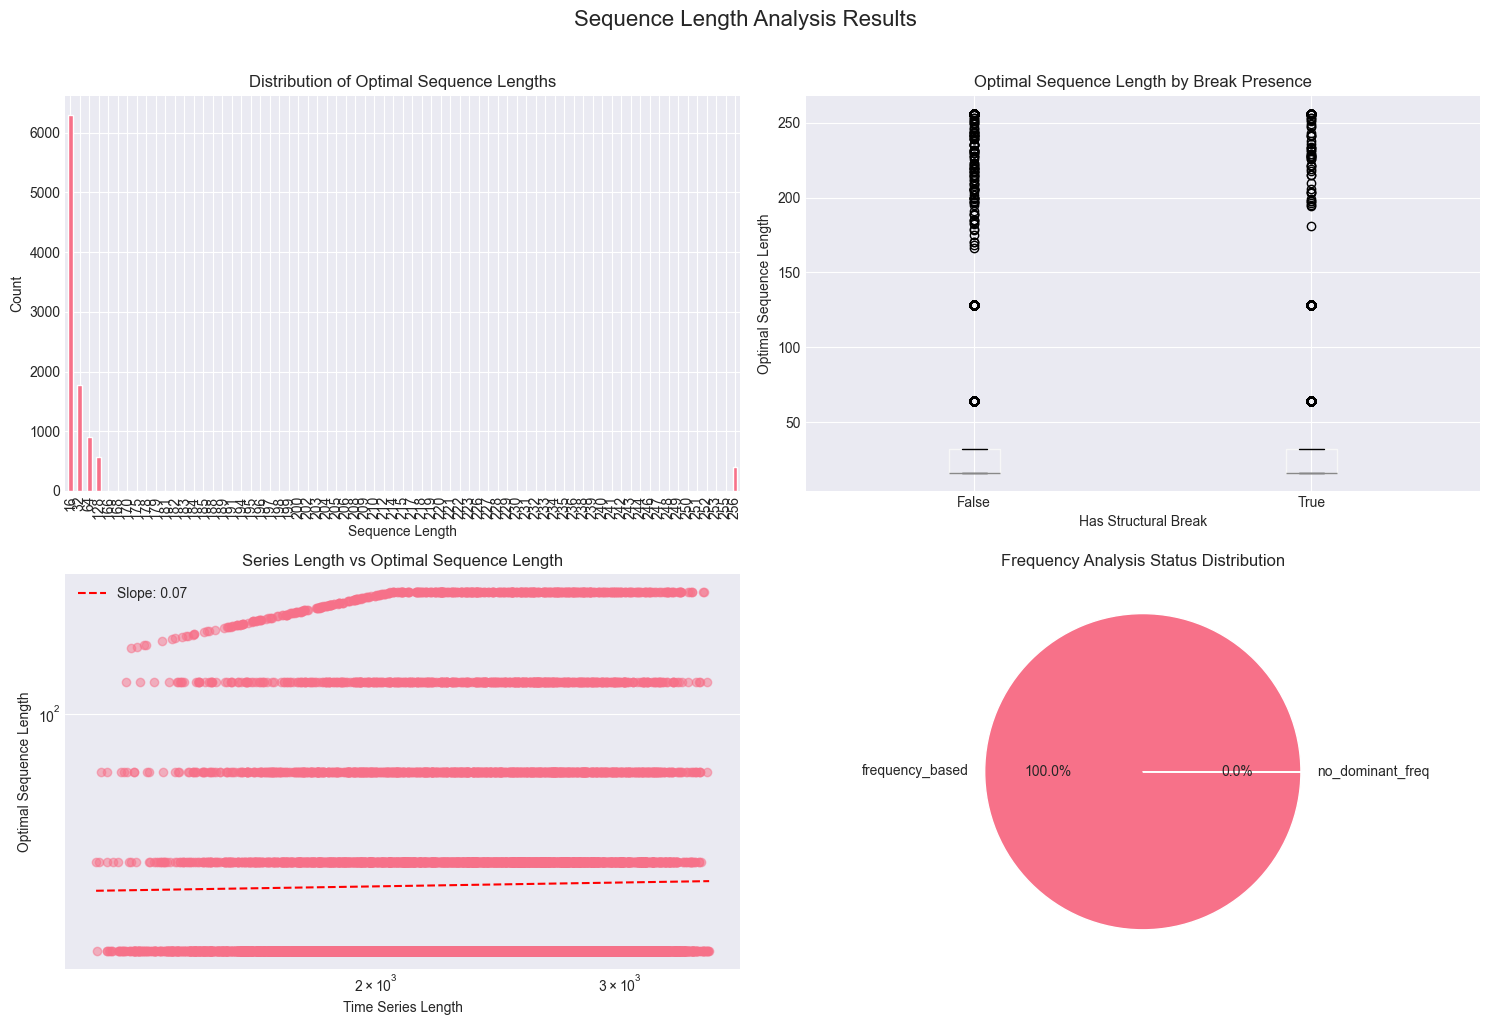

In [95]:
# Visualize sequence length distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Overall distribution of optimal sequence lengths
ax = axes[0, 0]
seq_length_df['optimal_length'].value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title('Distribution of Optimal Sequence Lengths')
ax.set_xlabel('Sequence Length')
ax.set_ylabel('Count')

# 2. Distribution by break/no-break (train data only)
ax = axes[0, 1]
train_seq = seq_length_df[seq_length_df['is_train'] & seq_length_df['has_break'].notna()]
if len(train_seq) > 0:
    train_seq.boxplot(column='optimal_length', by='has_break', ax=ax)
    ax.set_title('Optimal Sequence Length by Break Presence')
    ax.set_xlabel('Has Structural Break')
    ax.set_ylabel('Optimal Sequence Length')

# 3. Relationship between series length and optimal sequence length
ax = axes[1, 0]
ax.scatter(seq_length_df['series_length'], seq_length_df['optimal_length'], alpha=0.5)
ax.set_xlabel('Time Series Length')
ax.set_ylabel('Optimal Sequence Length')
ax.set_title('Series Length vs Optimal Sequence Length')
ax.set_xscale('log')
ax.set_yscale('log')

# Add trend line
from sklearn.linear_model import LinearRegression

X = np.log(seq_length_df['series_length'].values).reshape(-1, 1)
y = np.log(seq_length_df['optimal_length'].values)
reg = LinearRegression().fit(X, y)
X_pred = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred = reg.predict(X_pred)
ax.plot(np.exp(X_pred), np.exp(y_pred), 'r--', label=f'Slope: {reg.coef_[0]:.2f}')
ax.legend()

# 4. Frequency analysis status
ax = axes[1, 1]
status_counts = seq_length_df['status'].value_counts()
status_counts.plot(kind='pie', ax=ax, autopct='%1.1f%%')
ax.set_title('Frequency Analysis Status Distribution')
ax.set_ylabel('')

plt.tight_layout()
plt.suptitle('Sequence Length Analysis Results', y=1.02, fontsize=16)
plt.show()

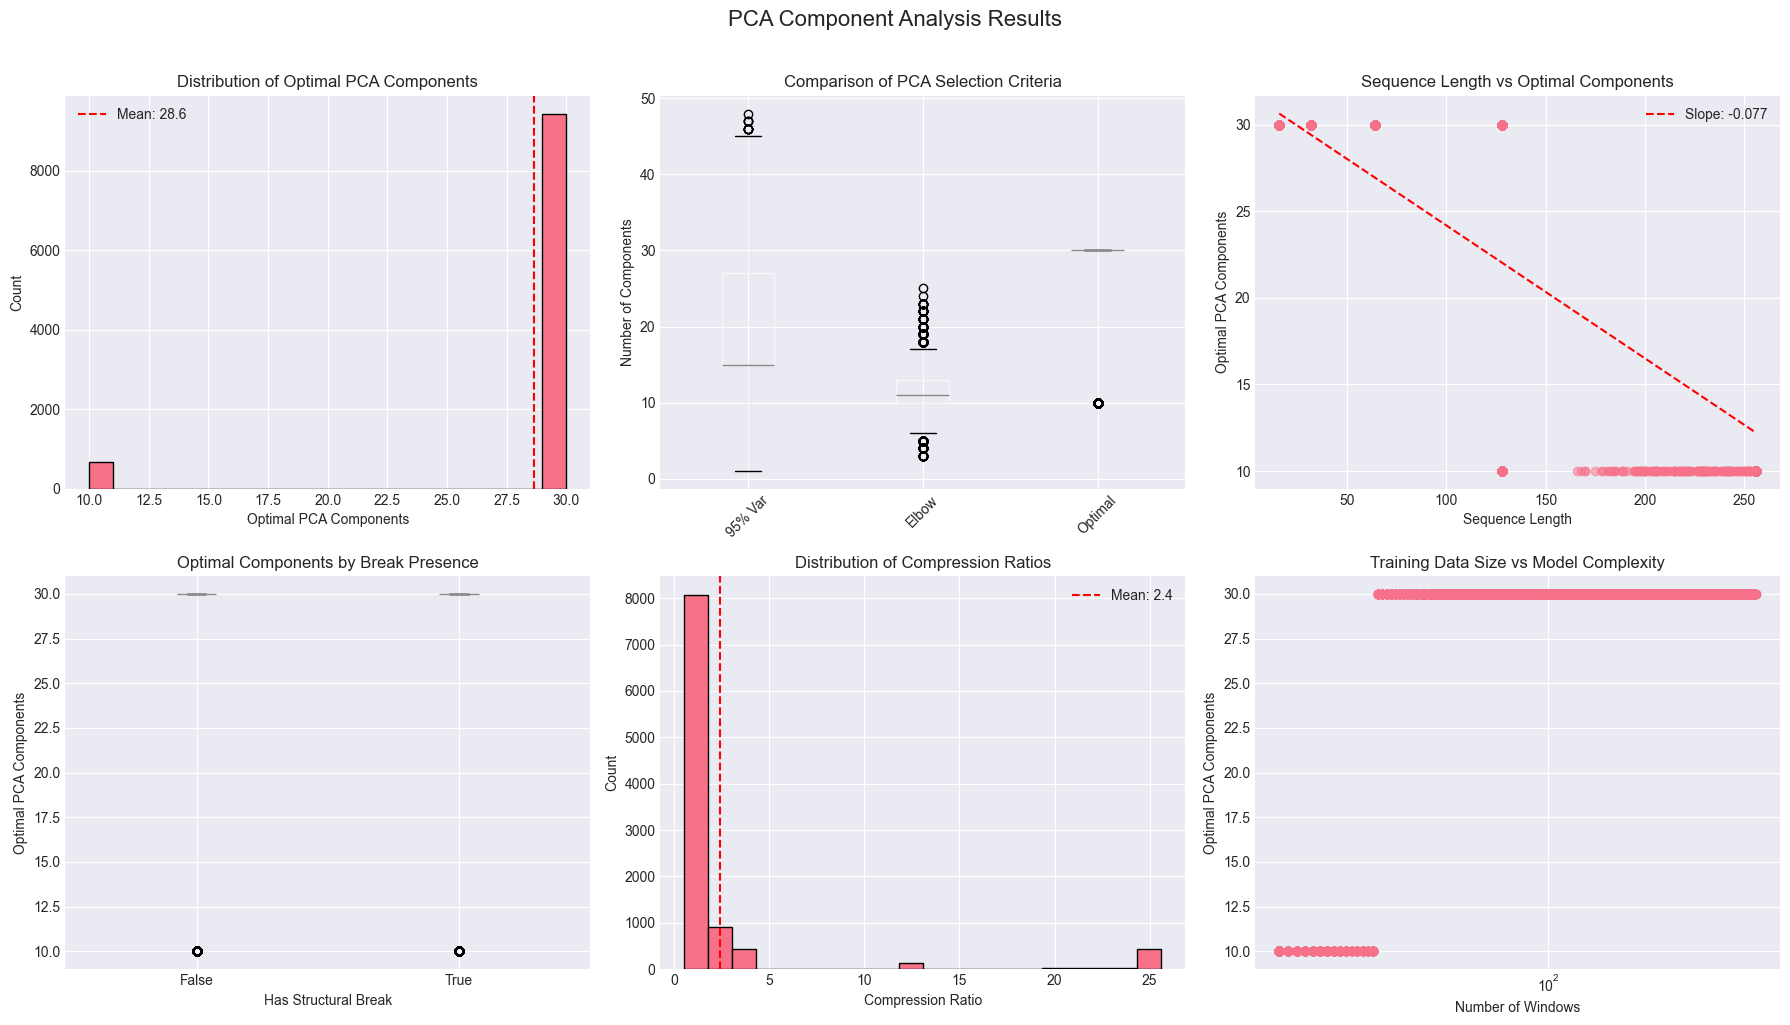

In [97]:
# Visualize PCA component distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Distribution of optimal components
ax = axes[0, 0]
pca_df['optimal_components'].hist(bins=20, ax=ax, edgecolor='black')
ax.set_xlabel('Optimal PCA Components')
ax.set_ylabel('Count')
ax.set_title('Distribution of Optimal PCA Components')
ax.axvline(pca_df['optimal_components'].mean(), color='red', linestyle='--',
           label=f'Mean: {pca_df["optimal_components"].mean():.1f}')
ax.legend()

# 2. Comparison of different criteria
ax = axes[0, 1]
criteria_df = pca_df[['n_components_95', 'n_components_elbow', 'optimal_components']].dropna()
if len(criteria_df) > 0:
    criteria_df.boxplot(ax=ax)
    ax.set_title('Comparison of PCA Selection Criteria')
    ax.set_ylabel('Number of Components')
    ax.set_xticklabels(['95% Var', 'Elbow', 'Optimal'], rotation=45)

# 3. Optimal components vs sequence length
ax = axes[0, 2]
ax.scatter(pca_df['sequence_length'], pca_df['optimal_components'], alpha=0.5)
ax.set_xlabel('Sequence Length')
ax.set_ylabel('Optimal PCA Components')
ax.set_title('Sequence Length vs Optimal Components')

# Add trend line
X = pca_df['sequence_length'].values.reshape(-1, 1)
y = pca_df['optimal_components'].values
reg = LinearRegression().fit(X, y)
X_pred = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred = reg.predict(X_pred)
ax.plot(X_pred, y_pred, 'r--', label=f'Slope: {reg.coef_[0]:.3f}')
ax.legend()

# 4. Distribution by break presence (train only)
ax = axes[1, 0]
train_pca = pca_df[pca_df['is_train'] & pca_df['has_break'].notna()]
if len(train_pca) > 0:
    train_pca.boxplot(column='optimal_components', by='has_break', ax=ax)
    ax.set_title('Optimal Components by Break Presence')
    ax.set_xlabel('Has Structural Break')
    ax.set_ylabel('Optimal PCA Components')

# 5. Compression ratio distribution
ax = axes[1, 1]
pca_df['compression_ratio'] = pca_df['sequence_length'] / pca_df['optimal_components']
pca_df['compression_ratio'].hist(bins=20, ax=ax, edgecolor='black')
ax.set_xlabel('Compression Ratio')
ax.set_ylabel('Count')
ax.set_title('Distribution of Compression Ratios')
ax.axvline(pca_df['compression_ratio'].mean(), color='red', linestyle='--',
           label=f'Mean: {pca_df["compression_ratio"].mean():.1f}')
ax.legend()

# 6. Number of windows vs optimal components
ax = axes[1, 2]
ax.scatter(pca_df['n_windows'], pca_df['optimal_components'], alpha=0.5)
ax.set_xlabel('Number of Windows')
ax.set_ylabel('Optimal PCA Components')
ax.set_title('Training Data Size vs Model Complexity')
ax.set_xscale('log')

plt.tight_layout()
plt.suptitle('PCA Component Analysis Results', y=1.02, fontsize=16)
plt.show()

In [100]:
# Summary statistics
print("\n=== SEQUENCE LENGTH ANALYSIS SUMMARY ===")
print(f"Total series analyzed: {len(seq_length_df)}")
print(f"\nOptimal sequence length statistics:")
print(seq_length_df['optimal_length'].describe())
print(f"\nMost common sequence lengths:")
print(seq_length_df['optimal_length'].value_counts().head(10))
print(f"\nFrequency analysis status:")
print(seq_length_df['status'].value_counts())

print("\n=== PCA COMPONENT ANALYSIS SUMMARY ===")
print(f"Total series analyzed: {len(pca_df)}")
print(f"\nOptimal PCA components statistics:")
print(pca_df['optimal_components'].describe())
print(f"\nCompression ratio statistics:")
print(pca_df['compression_ratio'].describe())

# Compare by structural break presence
if len(train_pca) > 0:
    print("\n=== COMPARISON BY STRUCTURAL BREAK ===")
    grouped = train_pca.groupby('has_break')

    print("\nOptimal sequence length by break:")
    seq_grouped = train_seq.groupby('has_break')
    print(seq_grouped['optimal_length'].agg(['mean', 'std', 'median']))

    print("\nOptimal PCA components by break:")
    print(grouped['optimal_components'].agg(['mean', 'std', 'median']))

    print("\nCompression ratio by break:")
    print(grouped['compression_ratio'].agg(['mean', 'std', 'median']))


=== SEQUENCE LENGTH ANALYSIS SUMMARY ===
Total series analyzed: 10102

Optimal sequence length statistics:
count    10102.000000
mean        42.050188
std         56.707580
min         16.000000
25%         16.000000
50%         16.000000
75%         32.000000
max        256.000000
Name: optimal_length, dtype: float64

Most common sequence lengths:
optimal_length
16     6303
32     1773
64      905
128     565
256     403
206       5
241       5
228       5
215       5
200       4
Name: count, dtype: int64

Frequency analysis status:
status
frequency_based     10097
no_dominant_freq        5
Name: count, dtype: int64

=== PCA COMPONENT ANALYSIS SUMMARY ===
Total series analyzed: 10102

Optimal PCA components statistics:
count    10102.000000
mean        28.641853
std          5.031986
min         10.000000
25%         30.000000
50%         30.000000
75%         30.000000
max         30.000000
Name: optimal_components, dtype: float64

Compression ratio statistics:
count    10102.000000

KeyError: 'Column not found: compression_ratio'


=== EXPLAINED VARIANCE ANALYSIS ===


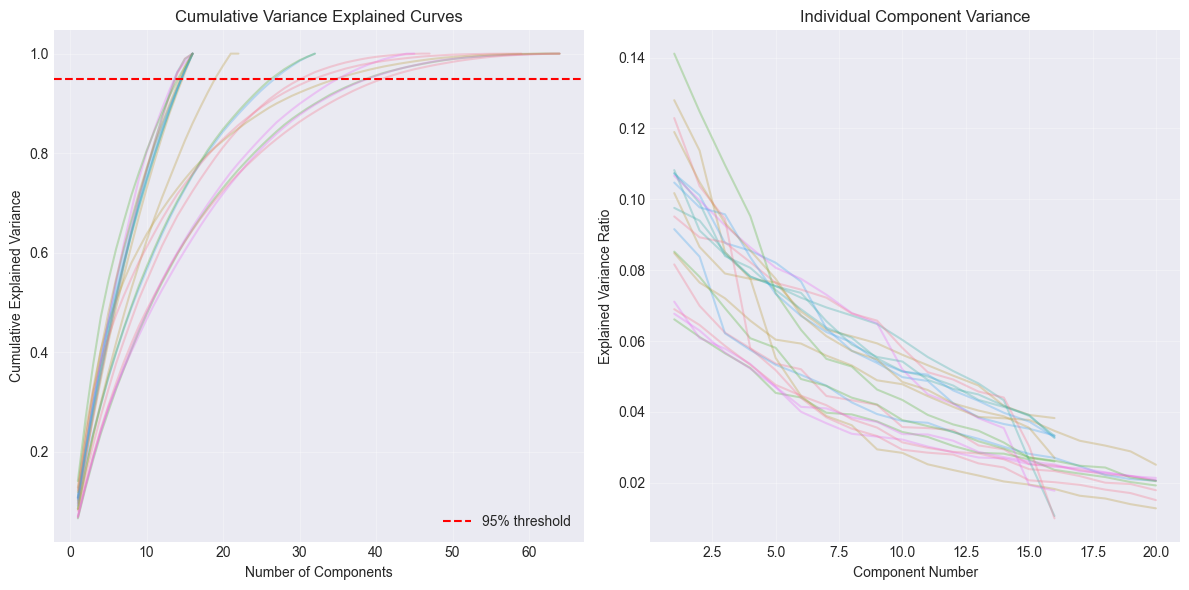

In [101]:
# Analyze explained variance curves
print("\n=== EXPLAINED VARIANCE ANALYSIS ===")

# Sample some series to show explained variance curves
sample_indices = np.random.choice(len(analysis_metadata), size=min(20, len(analysis_metadata)), replace=False)

plt.figure(figsize=(12, 6))

# Plot cumulative variance curves
plt.subplot(1, 2, 1)
for idx in sample_indices:
    meta = analysis_metadata[idx]
    if meta['cumulative_variance'] is not None:
        plt.plot(range(1, len(meta['cumulative_variance']) + 1),
                 meta['cumulative_variance'], alpha=0.3)

plt.axhline(0.95, color='red', linestyle='--', label='95% threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance Explained Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot individual explained variance
plt.subplot(1, 2, 2)
for idx in sample_indices:
    meta = analysis_metadata[idx]
    if meta['explained_variance_ratio'] is not None and len(meta['explained_variance_ratio']) > 0:
        plt.plot(range(1, min(21, len(meta['explained_variance_ratio']) + 1)),
                 meta['explained_variance_ratio'][:20], alpha=0.3)

plt.xlabel('Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Individual Component Variance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [102]:
# Create recommendation based on analysis
print("\n=== RECOMMENDATIONS ===")

# Sequence length recommendation
seq_mode = seq_length_df['optimal_length'].mode()[0]
seq_median = seq_length_df['optimal_length'].median()

print(f"\n1. Sequence Length:")
print(f"   - Most common: {seq_mode}")
print(f"   - Median: {seq_median}")
print(f"   - Recommended default: {int(2 ** round(np.log2(seq_median)))}")
print(f"   - Range for 90% of data: {seq_length_df['optimal_length'].quantile(0.05):.0f} - "
      f"{seq_length_df['optimal_length'].quantile(0.95):.0f}")

# PCA components recommendation
pca_mode = pca_df['optimal_components'].mode()[0] if len(pca_df) > 0 else 10
pca_median = pca_df['optimal_components'].median() if len(pca_df) > 0 else 10

print(f"\n2. PCA Components (Bottleneck Dimension):")
print(f"   - Most common: {pca_mode}")
print(f"   - Median: {pca_median}")
print(f"   - Recommended default: {int(pca_median)}")
print(f"   - Range for 90% of data: {pca_df['optimal_components'].quantile(0.05):.0f} - "
      f"{pca_df['optimal_components'].quantile(0.95):.0f}")

print(f"\n3. Compression Ratio:")
print(f"   - Mean: {pca_df['compression_ratio'].mean():.1f}:1")
print(f"   - This suggests the autoencoder can achieve good compression")


=== RECOMMENDATIONS ===

1. Sequence Length:
   - Most common: 16
   - Median: 16.0
   - Recommended default: 16
   - Range for 90% of data: 16 - 212

2. PCA Components (Bottleneck Dimension):
   - Most common: 30
   - Median: 30.0
   - Recommended default: 30
   - Range for 90% of data: 10 - 30

3. Compression Ratio:
   - Mean: 2.4:1
   - This suggests the autoencoder can achieve good compression


In [103]:
# Save results for future use
results_dict = {
    'sequence_length_analysis': seq_length_df,
    'pca_analysis': pca_df,
    'detailed_metadata': analysis_metadata,
    'recommendations': {
        'sequence_length': int(2 ** round(np.log2(seq_median))),
        'pca_components': int(pca_median),
        'compression_ratio': pca_df['compression_ratio'].mean()
    }
}

# Optionally save to file
# import pickle
# with open('dataset_analysis_results.pkl', 'wb') as f:
#     pickle.dump(results_dict, f)

print("\n=== Analysis Complete ===")
print(f"Results stored in 'results_dict' variable")
print(f"Access individual analyses via:")
print(f"  - results_dict['sequence_length_analysis']")
print(f"  - results_dict['pca_analysis']")
print(f"  - results_dict['recommendations']")


=== Analysis Complete ===
Results stored in 'results_dict' variable
Access individual analyses via:
  - results_dict['sequence_length_analysis']
  - results_dict['pca_analysis']
  - results_dict['recommendations']
